# Whole space decomposition

If the initial state is a superposition of states that belong to different magnetization eigenspace is not possible to use the single column decomposition, with4 c-not (see decomposition.ipynb). 

Here we describe the best decomposition for any initial state, that has 11 c-not (14 with the jakarta geometry). 

# 1) Idea explanation

If we see the single trotter step matrix we understand that it acts indipendently on each parity subspace.

In [1]:
from functions0 import *
from sympy import *

parameter = Symbol("alpha", real=True)

Trotter_Step_Matrix = trotter_step_matrix(parameter)
Trotter_Step_Matrix

Matrix([
[exp(-I*alpha),                                     0,                                     0,             0,             0,                                     0,                                     0,             0],
[            0,                            cos(alpha),                         -I*sin(alpha),             0,             0,                                     0,                                     0,             0],
[            0, -I*exp(I*alpha)*sin(alpha)*cos(alpha),            exp(I*alpha)*cos(alpha)**2,             0, -I*sin(alpha),                                     0,                                     0,             0],
[            0,                                     0,                                     0,    cos(alpha),             0, -I*exp(I*alpha)*sin(alpha)*cos(alpha),           -exp(I*alpha)*sin(alpha)**2,             0],
[            0,           -exp(I*alpha)*sin(alpha)**2, -I*exp(I*alpha)*sin(alpha)*cos(alpha),             0,    cos(alp

So what we've done is to find a base where the Trotter_Step_Matrix is in the form:

$
T_{step} = M \otimes Id_{2x2}
$

Where M is the matrix of a fixed parity.

In [2]:
from sympy.physics.quantum import TensorProduct as Tp

B = Matrix([
    [0,0,0,0,1,0,0,0],
    [0,0,1,0,0,0,0,0],
    [0,1,0,0,0,0,0,0],
    [1,0,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,0],
    [0,0,0,0,0,1,0,0],
    [0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,1]
])
B

Matrix([
[0, 0, 0, 0, 1, 0, 0, 0],
[0, 0, 1, 0, 0, 0, 0, 0],
[0, 1, 0, 0, 0, 0, 0, 0],
[1, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 1, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 1, 0, 0],
[0, 0, 0, 0, 0, 0, 1, 0],
[0, 0, 0, 0, 0, 0, 0, 1]])

In [3]:
B*Trotter_Step_Matrix*B.H

Matrix([
[   cos(alpha), -I*exp(I*alpha)*sin(alpha)*cos(alpha),           -exp(I*alpha)*sin(alpha)**2,             0,             0,                                     0,                                     0,             0],
[-I*sin(alpha),            exp(I*alpha)*cos(alpha)**2, -I*exp(I*alpha)*sin(alpha)*cos(alpha),             0,             0,                                     0,                                     0,             0],
[            0,                         -I*sin(alpha),                            cos(alpha),             0,             0,                                     0,                                     0,             0],
[            0,                                     0,                                     0, exp(-I*alpha),             0,                                     0,                                     0,             0],
[            0,                                     0,                                     0,             0,    cos(alp

This matrix conrresponds to a cirquit that acts only on the first two qubits because it's the tensor product of a 4x4 matrix with the identity 2x2.

Since the B operator is just a permutation of qubits, so a base changing, we can change tha base before the evolution and apply N trotter steps in the new base:

$
B \cdot T_{step}^N \cdot B^{+} =( B \cdot T_{step} \cdot B^{+})\cdot (  B \cdot T_{step} \cdot B^{+}) \cdot ... \cdot (B \cdot T_{step} \cdot B^{+}) = (M \otimes Id_{2x2})^N
$

But in our circuit, to optimize the number of c-not, insted of changing the base and than apply the evolution in the new base, we prepare the initial state already in the new base:

$
|\psi>_{prepared} = B^{+} \cdot |\psi>_{init} 
$

So finally we have:

$
T_{step}^N |\psi>_{init} =  B \cdot B^{+} \cdot T_{step}^N \cdot B \cdot B^{+} |\psi>_{init} = B \cdot( B^{+} \cdot T_{step}^N \cdot B) |\psi>_{prepared} = 
$

$
=  B \cdot (M \otimes Id_{2x2})^N |\psi>_{prepared} = B \cdot (M^N \otimes Id_{2x2}) |\psi>_{prepared}
$

Now, we have just to decompose these matrix in circuits.


# 2) Matrices to cirquits

## 2.1) B matrix

B is a permutation cirquit so is possible to make it just using x, c-x and toffoli gates.

Qua ruben spiega un po tu che cazzo te sei n'ventato

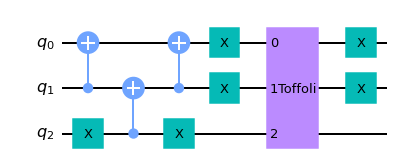

In [6]:
qr=QuantumRegister(3, name="q")
B_qc=QuantumCircuit(qr, name="B")
B_qc.x(qr[2])
B_qc.cx(qr[1],qr[0])
B_qc.cx(qr[2],qr[1])
B_qc.cx(qr[1],qr[0])
B_qc.x([qr[0],qr[1],qr[2]])
B_qc.append(Toffoli_gate(),[qr[0],qr[1],qr[2]])
B_qc.x([qr[0],qr[1]])

B_qc.draw(output="mpl")

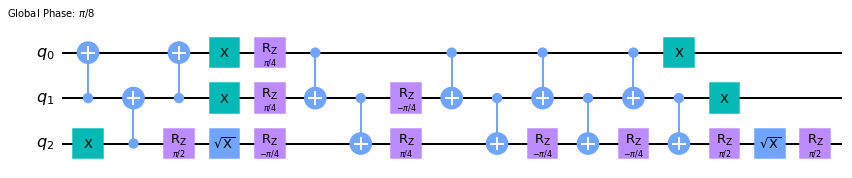

In [10]:
transpile(B_qc, basis_gates=["cx", "x", "rz", "sx"]).draw(output="mpl")

Where the best decomposition for the toffoli gate in jakarta geometry is (8 c-not):

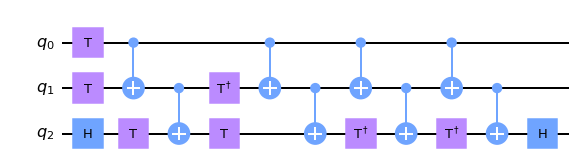

In [5]:
Toffoli_gate().draw(output="mpl")

## 2.1) $M^N$ matrix

The M matrix is the following:

In [12]:
M = B*Trotter_Step_Matrix*B.H
M = Matrix([M[0:4],M[8:12],M[16:20],M[24:28]])
M

Matrix([
[   cos(alpha), -I*exp(I*alpha)*sin(alpha)*cos(alpha),           -exp(I*alpha)*sin(alpha)**2,             0],
[-I*sin(alpha),            exp(I*alpha)*cos(alpha)**2, -I*exp(I*alpha)*sin(alpha)*cos(alpha),             0],
[            0,                         -I*sin(alpha),                            cos(alpha),             0],
[            0,                                     0,                                     0, exp(-I*alpha)]])

We compute numerically the product of M with itself N times.

In [17]:
n_steps = 42
time = np.pi
precision = 40

numeric_evolution_matrix=eye(8)

for _ in range(n_steps): # here is computed the evolution operator numerically, with n_steps trotter steps.
    numeric_evolution_matrix=(numeric_evolution_matrix*trotter_step_matrix(2*time/n_steps)).evalf(precision)

M_N = B*numeric_evolution_matrix*B.H
M_N = Matrix([M_N[0:4],M_N[8:12],M_N[16:20],M_N[24:28]])
M_N.evalf(5)

Matrix([
[   0.9999 + 0.0058176*I, -0.0012637 + 0.0058176*I,   0.0013669 - 0.011635*I,                  0],
[0.0013669 + 0.0058176*I,      0.9999 - 0.011635*I, -0.0012637 + 0.0058176*I,                  0],
[-0.0012637 - 0.011635*I,  0.0013669 + 0.0058176*I,     0.9999 + 0.0058176*I,                  0],
[                      0,                        0,                        0, 1.0 - 1.4365e-16*I]])

then using transpile we get the best decomposition

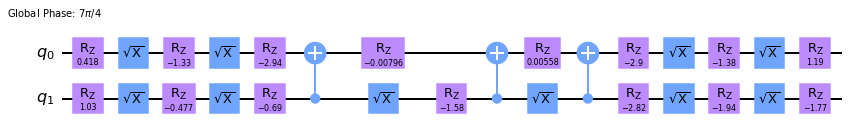

In [39]:
qc=QuantumCircuit(2, name="$M^N$")
qc.unitary(M_N,[0,1])    
M_N_qc=transpile(qc,basis_gates=['cx','x','sx','rz']) 

M_N_qc.draw(output="mpl")

So now we can built the final cirquit

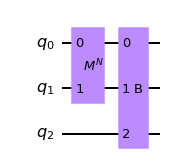

In [40]:
initial_state="000"

qr = QuantumRegister(3, name="q")
qc = QuantumCircuit(qr, name="evo")

### preparing the initial state

l=0
for k in [2,1,0]:
    if initial_state[l]=='1':
        qc.x(qr[k])
    l+=1

### appending the evolution

qc.append(M_N_qc,[qr[0],qr[1]])
qc.append(B_qc,[qr[0],qr[1],qr[2]])

qc.draw(output="mpl")

ora faccio una verifica ma possiamo anche non metterla

In [34]:
def matrix_from_cirquit(qc, phase=0):

    backend = Aer.get_backend('unitary_simulator')
    job = execute(qc, backend, shots=32000)
    result = job.result()
    A=result.get_unitary(qc, decimals=10)*np.exp(1j*phase)
    return Matrix(A)


In [35]:
DDDD = matrix_from_cirquit(qc)
DDDD

Matrix([
[                             0,                              0,                              0,   0,  0.9998967287 + 0.0058175983*I, -0.0012636571 + 0.0058175983*I,  0.0013669285 - 0.0116351967*I,   0],
[-0.0012636571 - 0.0116351967*I,  0.0013669285 + 0.0058175983*I,  0.9998967287 + 0.0058175983*I,   0,                              0,                              0,                              0,   0],
[ 0.0013669285 + 0.0058175983*I,  0.9998967287 - 0.0116351967*I, -0.0012636571 + 0.0058175983*I,   0,                              0,                              0,                              0,   0],
[ 0.9998967287 + 0.0058175983*I, -0.0012636571 + 0.0058175983*I,  0.0013669285 - 0.0116351967*I,   0,                              0,                              0,                              0,   0],
[                             0,                              0,                              0, 1.0,                              0,                              0,          

In [36]:
DDDD*B.H

Matrix([
[ 0.9998967287 + 0.0058175983*I,                              0,                              0,                              0,   0, -0.0012636571 + 0.0058175983*I,  0.0013669285 - 0.0116351967*I,   0],
[                             0,  0.9998967287 + 0.0058175983*I,  0.0013669285 + 0.0058175983*I, -0.0012636571 - 0.0116351967*I,   0,                              0,                              0,   0],
[                             0, -0.0012636571 + 0.0058175983*I,  0.9998967287 - 0.0116351967*I,  0.0013669285 + 0.0058175983*I,   0,                              0,                              0,   0],
[                             0,  0.0013669285 - 0.0116351967*I, -0.0012636571 + 0.0058175983*I,  0.9998967287 + 0.0058175983*I,   0,                              0,                              0,   0],
[                             0,                              0,                              0,                              0, 1.0,                              0,          